# Twitter Sentiment Analysis and Classification  
# Author: Adeyeye Blessing Temidayo 
# CIN: PIT/DEC25/10676 
# Data Source: 
 https://www.kaggle.com/c/titanic/data

# Project overview: 
This notebook performs a comprehensive analysis of the Titanic dataset to predict passenger survival using machine learning techniques. The analysis includes data cleaning, exploratory data analysis, feature engineering, and predictive modeling using Logistic Regression and XGBOOST.


#  Environment Setup & Libraries  

In [82]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
roc_auc_score, average_precision_score,RocCurveDisplay, ConfusionMatrixDisplay)
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings("ignore", category=UserWarning, module='joblib')

# Data Loading

In [83]:
# Load all data and validate it has been successfully loaded
files = ['test.csv', 'train.csv']
for file in files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"{file} not found in current directory")

try:
    test_data = pd.read_csv('test.csv')
    train_data = pd.read_csv('train.csv')
    gender_data = pd.read_csv('gender_submission.csv')
    print(f"\nData loaded Succesfully")
except:
    print(f"Error loading data")


Data loaded Succesfully


In [84]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [85]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [86]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data inspection

In [87]:
# Check the dimension of the dataset (rows and columns)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [88]:
# descriptive statistics of numerical columns
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Missing values detection

In [89]:
# Check for missing values in the dataset
print(f"\nNumber of missing values:")
train_data.isnull().sum()


Number of missing values:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [90]:
# Percentage of missing values
for col in train_data.columns:
    pct = np.mean(train_data[col].isnull()) * 100
    print(f'{col} - {pct}%')

PassengerId - 0.0%
Survived - 0.0%
Pclass - 0.0%
Name - 0.0%
Sex - 0.0%
Age - 19.865319865319865%
SibSp - 0.0%
Parch - 0.0%
Ticket - 0.0%
Fare - 0.0%
Cabin - 77.10437710437711%
Embarked - 0.22446689113355783%


In [91]:
# Counts of 'Survived' passengers as a key feature 
train_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [92]:
# Counts of 'Sex' of passengers as a key feature
train_data['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [93]:
# Counts of 'Pclass' of passengers as a key feature
train_data['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

# Data cleaning and Preprocessing

In [94]:
# function to preprocess both train and test datasets
def preprocess_data(df):
    
    # Fill missing Age with median
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Fill missing Fare with median
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Fill missing Embarked with mode
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Drop Cabin due to high null count
    df.drop(['Cabin'], axis=1, inplace=True, errors='ignore')
    
    return df

# Application to both test and train dataset
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)


print(train_data.isnull().sum())
print(test_data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


# Exploratory Data Analysis
Visualizations using the train data set showing relationships of key features where the feature "survived" is the target variable

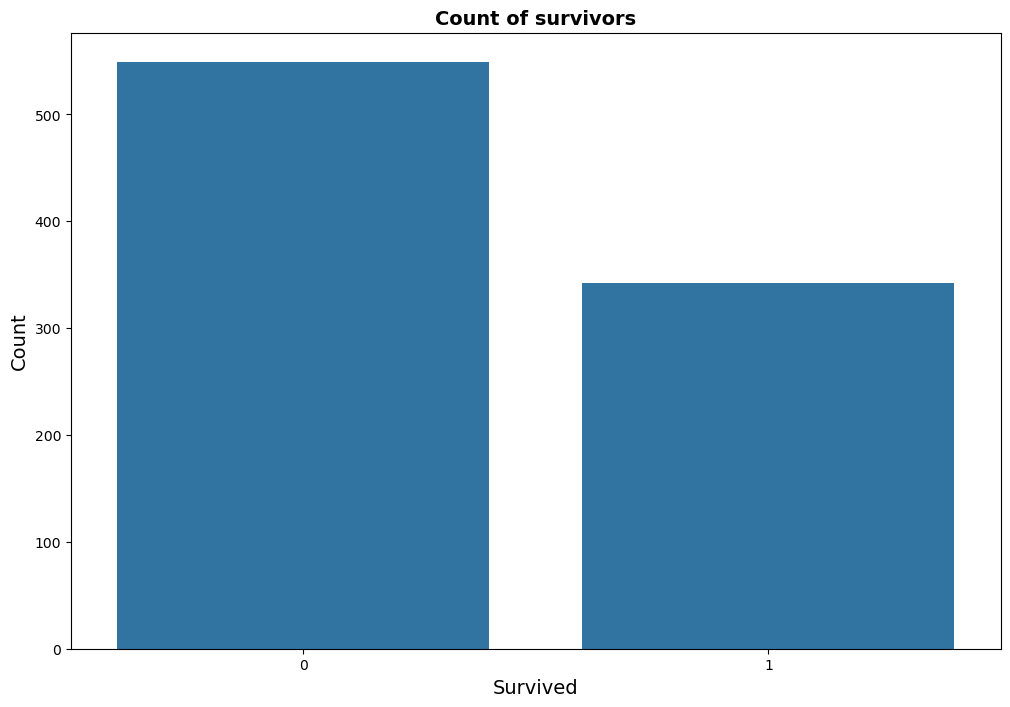

In [95]:
# plot of passengers who survived
plt.figure(figsize= (12,8))
sns.countplot(x='Survived', data=train_data)
plt.xlabel('Survived', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of survivors', fontsize=14, fontweight='bold')
plt.savefig('Titan_image/Count of survivors', dpi=300, bbox_inches='tight')
plt.show()

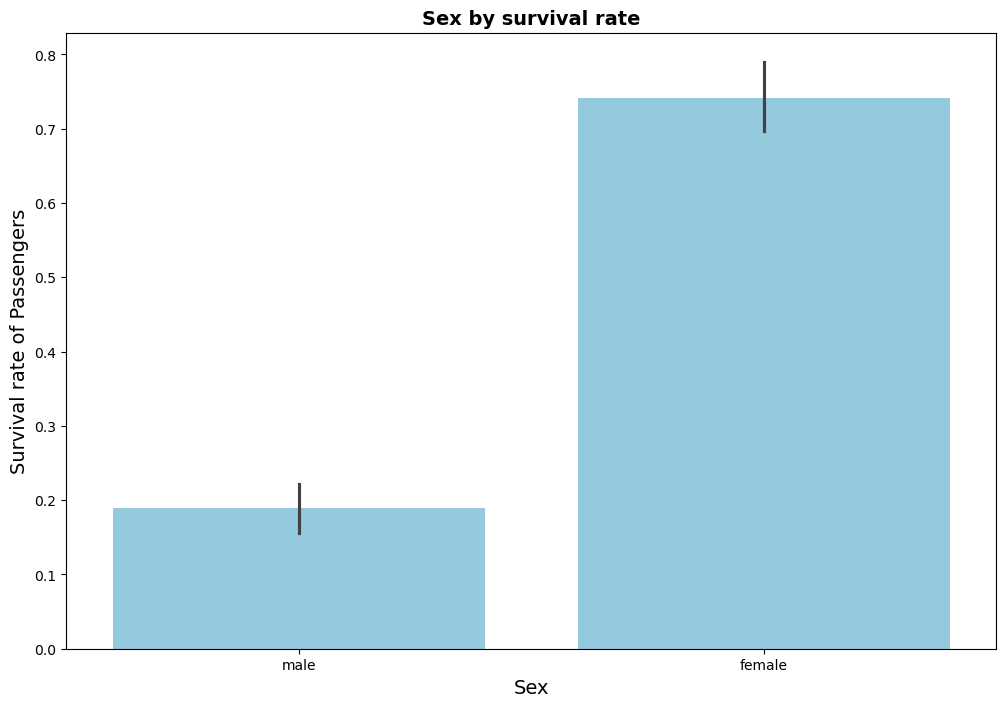

In [96]:
# Plot of passengers who survived by sex
plt.figure(figsize= (12,8))
sns.barplot(
    x='Sex',
    y= 'Survived',
    data = train_data,
    color = 'skyblue'
)

# Plot 
plt.title("Sex by survival rate", fontsize=14, fontweight='bold')
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Survival rate of Passengers",fontsize=14)
plt.savefig('Titan_image/Sex by survival rate', dpi=300, bbox_inches='tight')
plt.show()

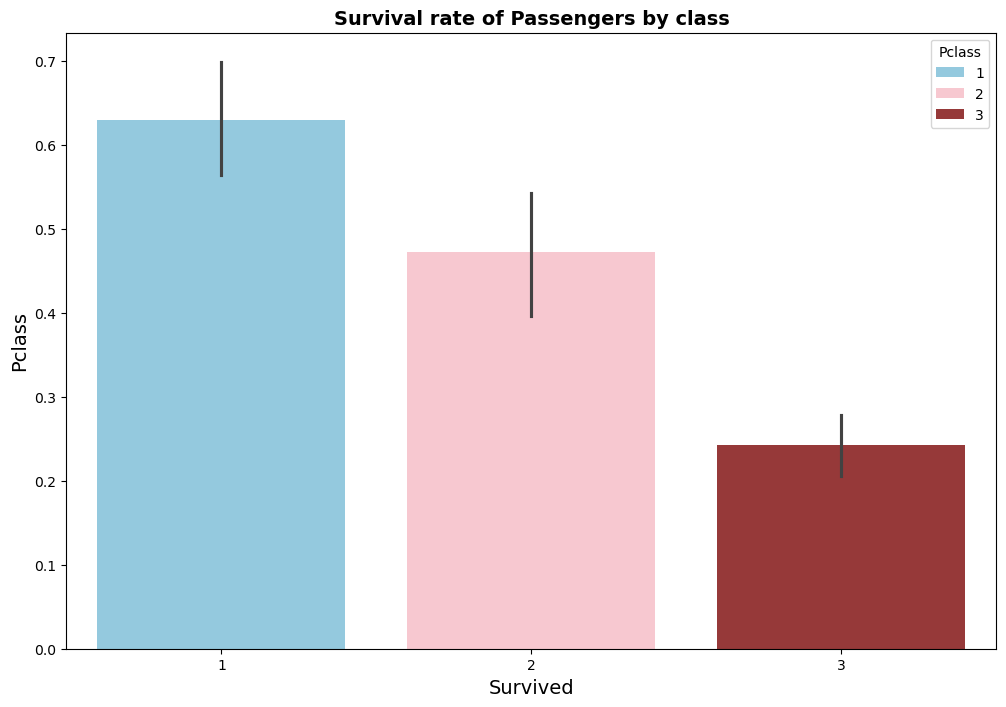

In [97]:
 # Plot of passengers who survived by class
plt.figure(figsize= (12,8))
sns.barplot(x='Pclass',y='Survived',data= train_data, hue='Pclass', palette= ['skyblue', 'pink', 'brown'])

# Plot
plt.title("Survival rate of Passengers by class", fontsize=14, fontweight='bold')
plt.xlabel("Survived", fontsize=14)
plt.ylabel("Pclass", fontsize=14)
plt.savefig('Titan_image/Survival rate of Passengers by class', dpi=300, bbox_inches='tight')
plt.show()

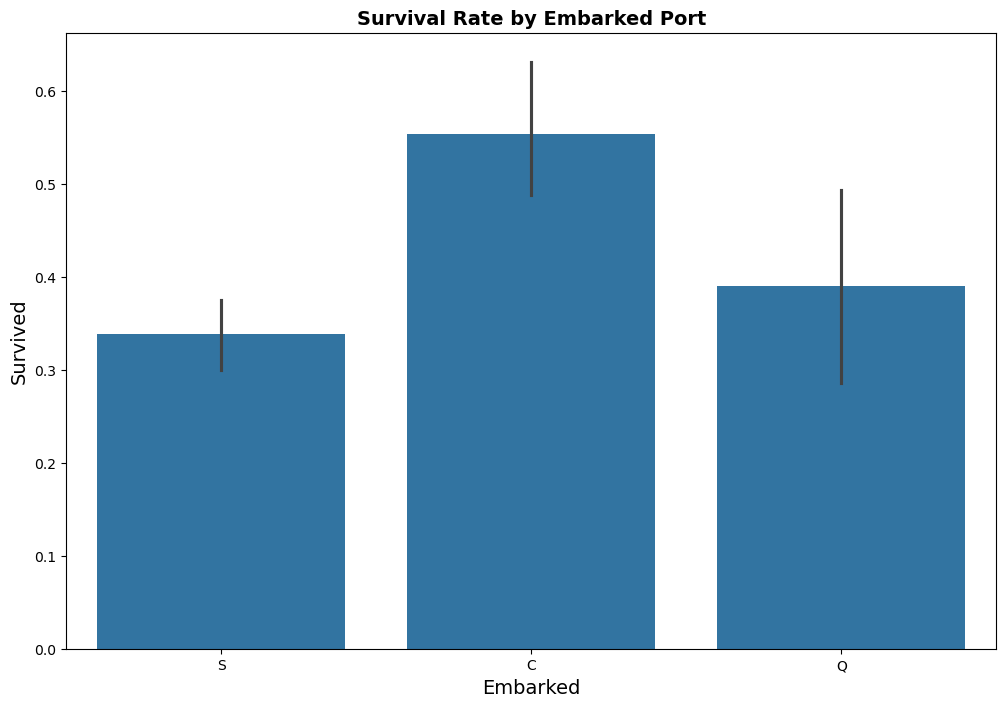

In [98]:
# Plot of Survival Rate by Embarked Port
plt.figure(figsize= (12,8))
sns.barplot(x='Embarked', y='Survived', data=train_data)
plt.xlabel("Embarked", fontsize=14)
plt.ylabel("Survived", fontsize=14)
plt.title('Survival Rate by Embarked Port', fontsize=14, fontweight='bold')
plt.savefig('Titan_image/Survival Rate by Embarked Port', dpi=300, bbox_inches='tight')
plt.show()

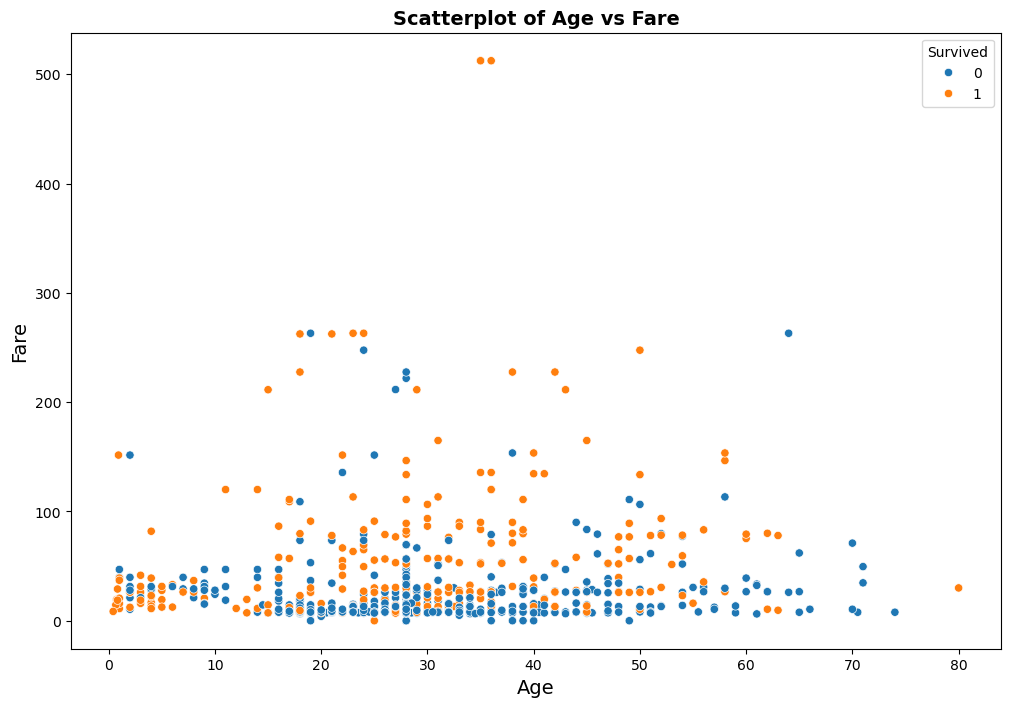

In [99]:
# Scatter plot of passengers by age, fare by survival rate
plt.figure(figsize= (12,8))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_data)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Fare", fontsize=14)
plt.title('Scatterplot of Age vs Fare', fontsize=14, fontweight='bold')
plt.savefig('Titan_image/Scatterplot of Age vs Fare', dpi=300, bbox_inches='tight')
plt.show()

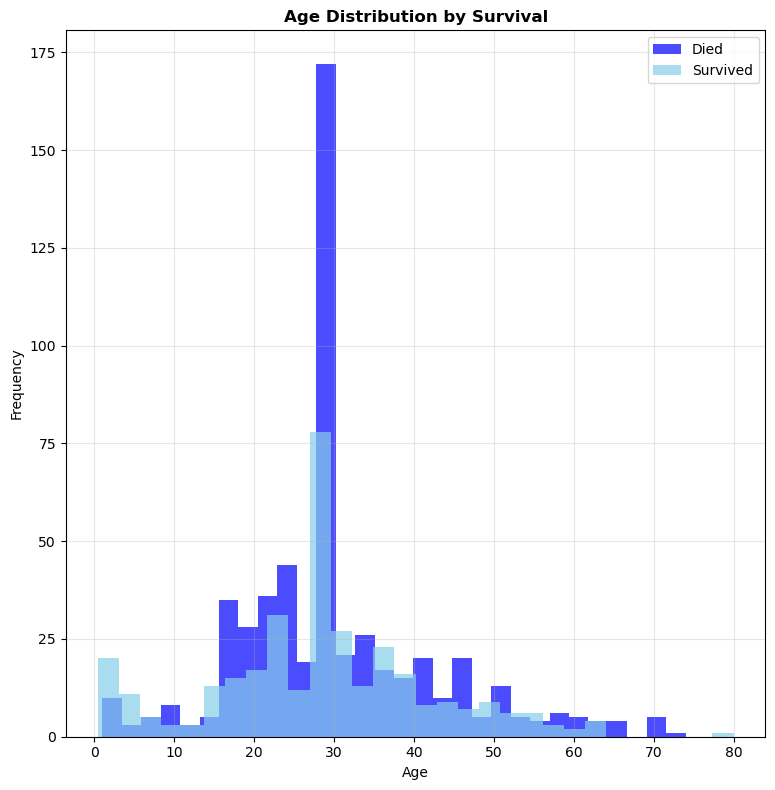

In [100]:
plt.figure(figsize=(15, 8))

# Subplot of Age Distribution
plt.subplot(1, 2, 1)
plt.hist(train_data[train_data['Survived'] == 0]['Age'], bins=30, alpha=0.7, color='blue', label='Died')
plt.hist(train_data[train_data['Survived'] == 1]['Age'], bins=30, alpha=0.7, color='skyblue', label='Survived')
plt.title('Age Distribution by Survival', fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Titan_image/Age Distribution by Survival', dpi=300, bbox_inches='tight')
plt.show()


##### Outlier Detection and Handling

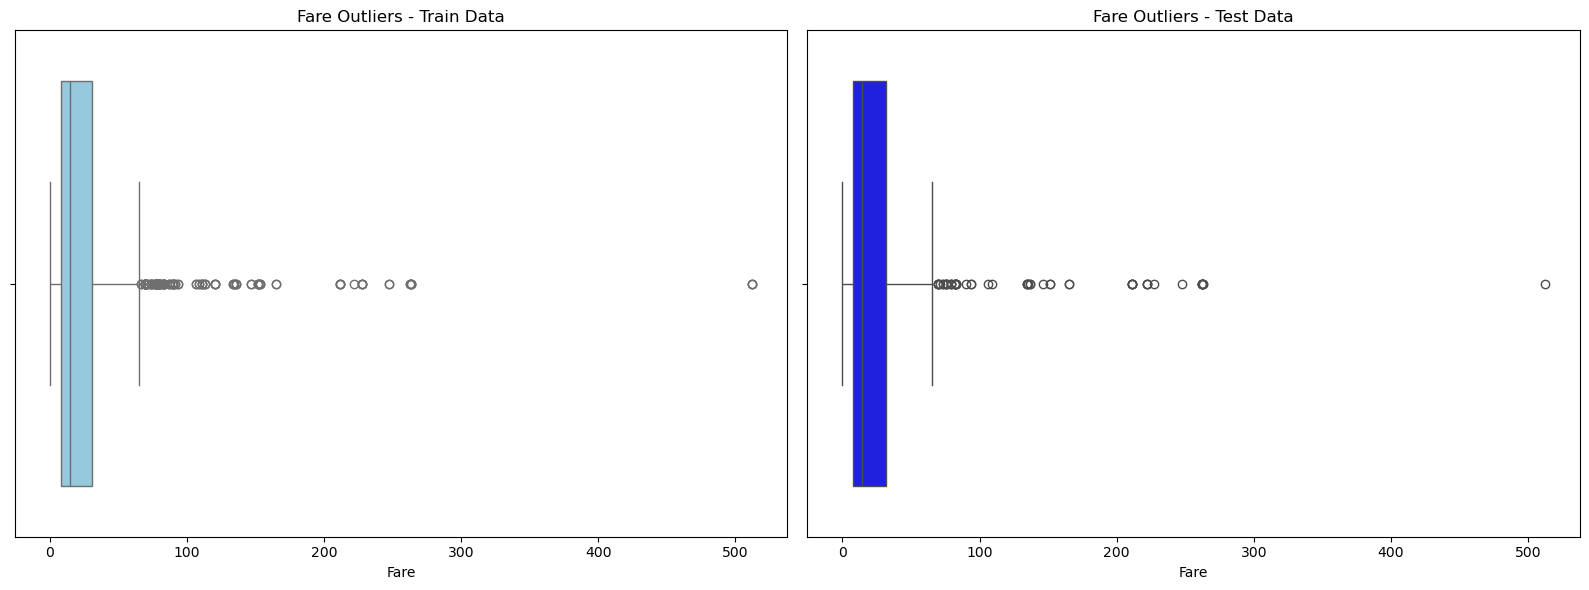

In [101]:
# Using boxplot to detect outlier in passenger fare
plt.figure(figsize=(16, 6))

# Plot for train Data
plt.subplot(1, 2, 1)
sns.boxplot(x=train_data['Fare'], color='skyblue')
plt.title('Fare Outliers - Train Data')

# Plot for Test Data
plt.subplot(1, 2, 2)
sns.boxplot(x=test_data['Fare'], color='blue')
plt.title('Fare Outliers - Test Data')
plt.tight_layout()
plt.savefig('Titan_image/Fare Outliers', dpi=300, bbox_inches='tight')
plt.show()

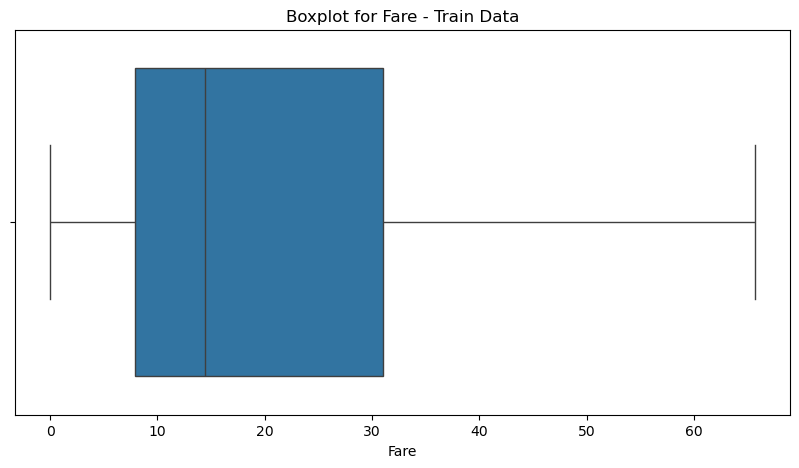

Train Data - Upper Bound: 65.6344
Train Data - Fare max value after capping: 65.6344


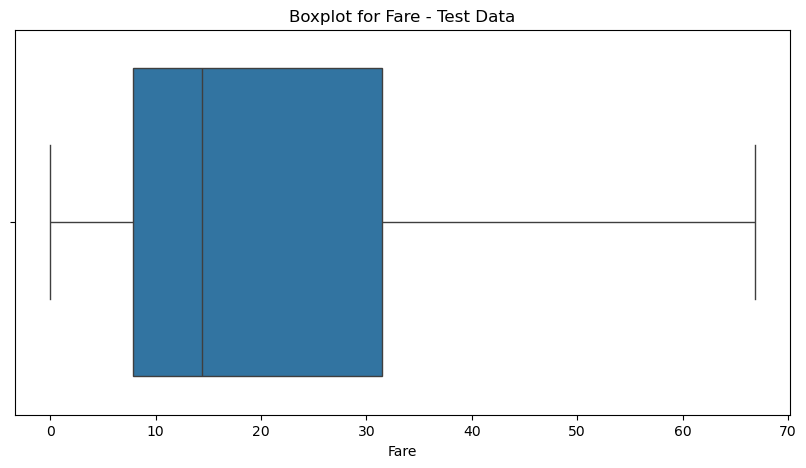

Test Data - Upper Bound: 66.8359875
Test Data - Fare max value after capping: 66.8359875


In [103]:
# Function to handle outlier and cap passenger Fare
def handle_fare_outliers(df, dataset_name="Dataset"):

    # plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Fare'])
    plt.title(f'Boxplot for Fare - {dataset_name}')
    plt.savefig('Titan_image/Boxplot for Fare', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate IQR
    Q1 = df['Fare'].quantile(0.25)
    Q3 = df['Fare'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df['Fare'] = np.where(df['Fare'] > upper_bound, upper_bound, df['Fare'])

    print(f"{dataset_name} - Upper Bound: {upper_bound}")
    print(f"{dataset_name} - Fare max value after capping: {df['Fare'].max()}")

    
    return df

# Apply to both
train_data = handle_fare_outliers(train_data, "Train Data")
test_data = handle_fare_outliers(test_data, "Test Data")

# Feature engineering

In [104]:
# Create new feature such as AgeGroup, FamilySize, IsAlone, FareGroup, and Title features using a function.
def new_features(df):
    # Age Binning
    age_bins = [0, 12, 18, 35, 60, 100]
    age_labels = ['Child', 'Teenager', 'Adult', 'middle_Age', 'Senior']
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

    # FamilySize 
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1 
    # IsAlone is 1 if FamilySize 
    df['Alone'] = (df['FamilySize'] == 1).astype(int)

    # Fare Binning
    fare_bins = df['Fare'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
    fare_labels = ['Low', 'Medium', 'High', 'Very_High']
    df['FareGroup'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)

    # Title Extraction & Grouping
    # Extract titles (e.g., Mr, Mrs, Miss) using regex
    df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
    
    # Standardize common titles and group rare ones
    rare_titles = ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"]
    df["Title"] = df["Title"].replace(rare_titles, "Rare")
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    
    return df

# Apply to both datasets
train_data = new_features(train_data)
test_data = new_features(test_data)

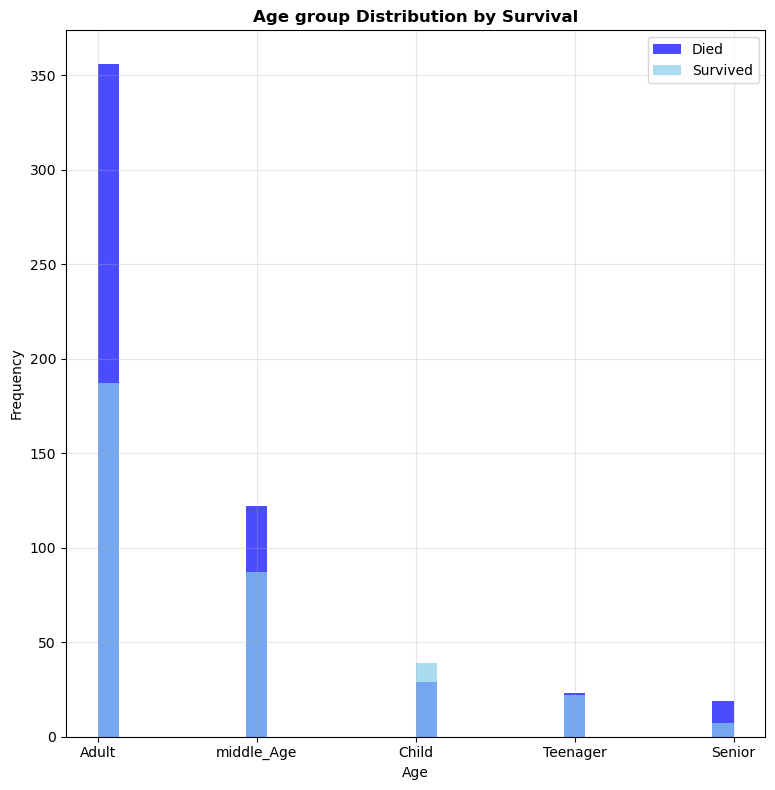

In [105]:
plt.figure(figsize=(15, 8))

# Subplot of Agegroup Distribution by survival
plt.subplot(1, 2, 1)
plt.hist(train_data[train_data['Survived'] == 0]['AgeGroup'], bins=30, alpha=0.7, color='blue', label='Died')
plt.hist(train_data[train_data['Survived'] == 1]['AgeGroup'], bins=30, alpha=0.7, color='skyblue', label='Survived')
plt.title('Age group Distribution by Survival', fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Titan_image/Age group Distribution by Survival', dpi=300, bbox_inches='tight')
plt.show()


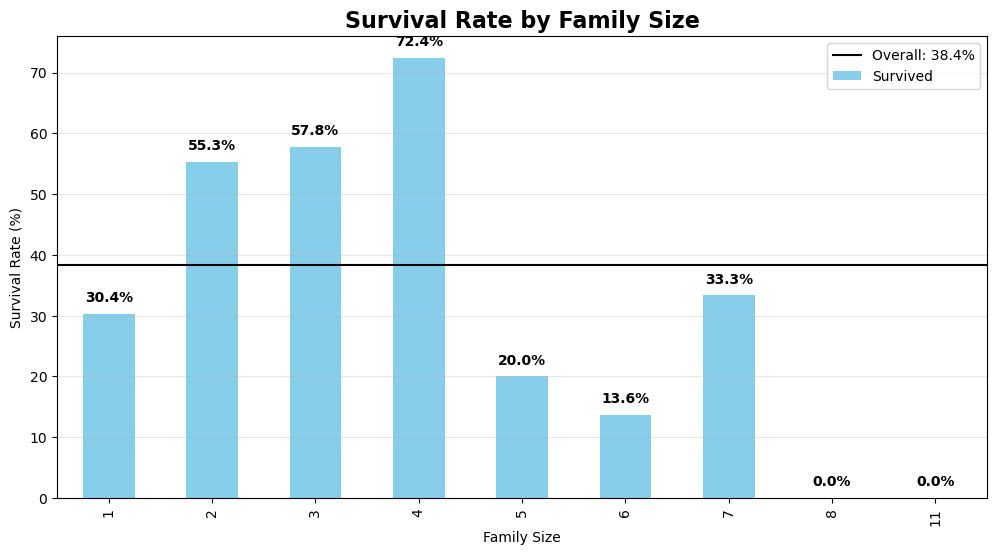

In [110]:
# Plot of Familsize
fam_surv = train_data.groupby('FamilySize')['Survived'].mean() * 100
plt.figure(figsize=(12, 6))
fam_surv.plot(kind='bar', color='skyblue')
plt.title('Survival Rate by Family Size', fontsize=16, fontweight='bold')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate (%)')
plt.grid(axis='y', alpha=0.3)

# Add labels
for i, v in enumerate(fam_surv):
    plt.text(i, v+2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.axhline(y=train_data['Survived'].mean()*100, color='black', 
           label=f'Overall: {train_data["Survived"].mean()*100:.1f}%')
plt.legend()

plt.savefig('Titan_image/Survival Rate by Family Size', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1600x600 with 0 Axes>

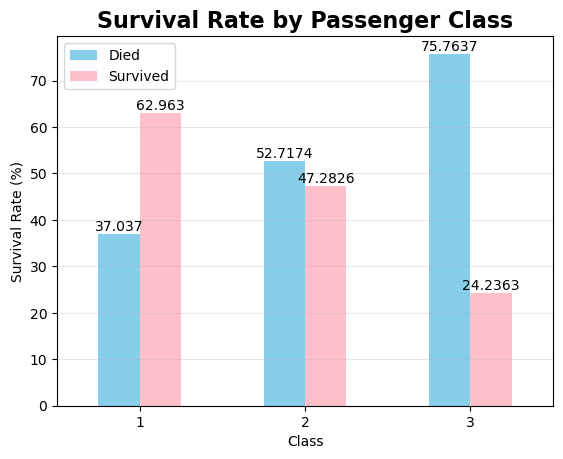

In [111]:
# plot of Survival Rate by Passenger Class
surv_class = pd.crosstab(train_data['Pclass'], train_data['Survived'], normalize='index') * 100

plt.figure(figsize=(16, 6))
surv_class.plot(kind='bar', color=['skyblue', 'pink', 'blue'])

plt.title('Survival Rate by Passenger Class', fontsize=16, fontweight='bold')
plt.ylabel('Survival Rate (%)')
plt.xlabel('Class')
plt.legend(['Died', 'Survived'])
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

for container in plt.gca().containers:
    plt.gca().bar_label(container)
    plt.savefig('Titan_image/Survival Rate by Passenger Class', dpi=300, bbox_inches='tight')
plt.show()


# Model building

In [112]:
# Define target and features
target = 'Survived' 
X = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', target], errors='ignore')
y = train_data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [113]:
# Extract column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

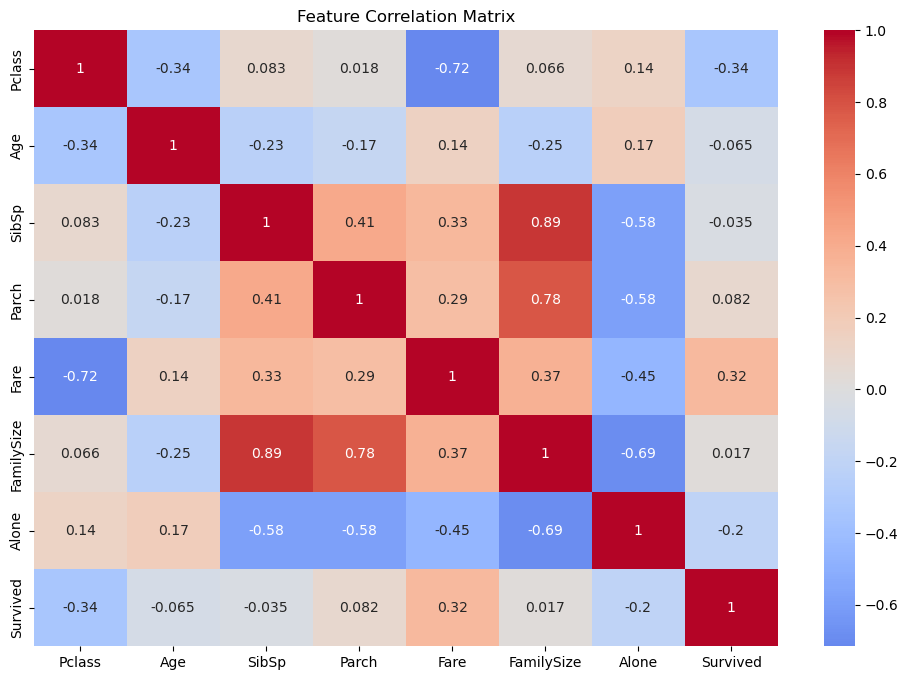

In [114]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_data[numeric_features + ['Survived']].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.savefig('Titan_image/Feature Correlation Matrix', dpi=300, bbox_inches='tight')
plt.show()

In [115]:
# Define Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [116]:
# Cross-validation with SMOTE (Due to class imbalance)
print("\nPerforming 5-Fold Cross-Validation with SMOTE")
cv_results = {}

# StratifiedKFold to ensure class proportions are maintained in folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
}

for name, model in models.items():
    # Use imblearn's Pipeline with preprocessor + SMOTE + classifier
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=skf,
        scoring='roc_auc', 
        n_jobs=-1
    )
    
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"\n{name}:")
    print(f"  Mean ROC-AUC: {cv_scores.mean():.4f}")
    print(f"  Std Dev: {cv_scores.std():.4f}")
    print(f"  95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, "
          f"{cv_scores.mean() + 1.96*cv_scores.std():.4f}]")



Performing 5-Fold Cross-Validation with SMOTE

Logistic Regression:
  Mean ROC-AUC: 0.8576
  Std Dev: 0.0322
  95% CI: [0.7946, 0.9207]

XGBoost:
  Mean ROC-AUC: 0.8473
  Std Dev: 0.0245
  95% CI: [0.7992, 0.8953]


### Hyperparameter Tuning 


In [117]:
# pipeline using the imbalanced-learn version
logReg_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression())
])
# logReg param
logReg_params = {
    'model__C': [0.001, 0.01, 0.1, 1],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear'],
    'model__class_weight': [None, 'balanced']
}

# GridSearch
logReg_grid = GridSearchCV(logReg_pipe, logReg_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
logReg_grid.fit(X_train, y_train)

print(f"Best params: {logReg_grid.best_params_}")
print(f"Best CV score: {logReg_grid.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best CV score: 0.8626675489497438



--- Logistic Regression - Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       165
           1       0.73      0.83      0.78       103

    accuracy                           0.82       268
   macro avg       0.81      0.82      0.81       268
weighted avg       0.82      0.82      0.82       268



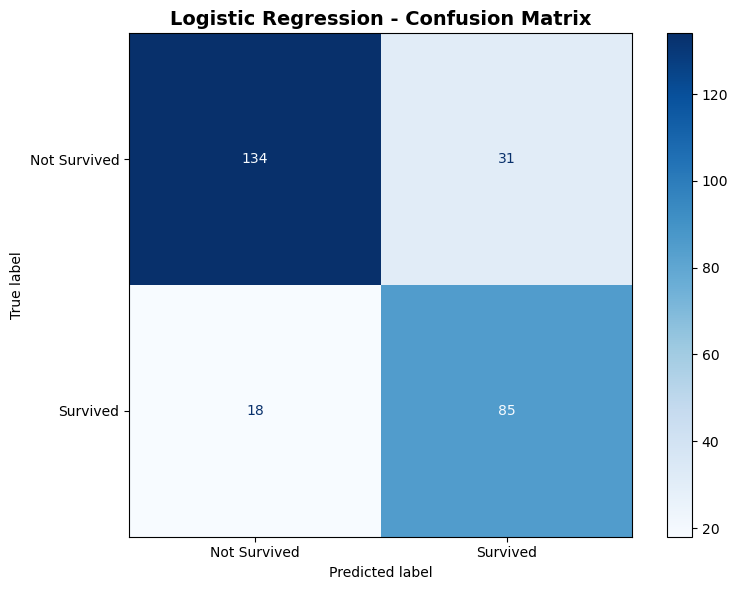

In [118]:
# Evaluate Logistic Regression on test set
best_logreg = logReg_grid.best_estimator_
y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression - Test Set Evaluation ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix for Logistic Regression
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_logreg, X_test, y_test, 
                                      display_labels=['Not Survived', 'Survived'], 
                                      cmap='Blues', ax=ax)
ax.set_title(f"Logistic Regression - Confusion Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Titan_image/Logistic Regression - Confusion Matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [119]:
# Hyperparameter Tuning - XGBoost
print("Tuning XGBoost")
xgb_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False))
])

xgb_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
xgb_grid.fit(X_train, y_train)
print(f"Best params: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")


Tuning XGBoost
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.9}
Best CV score: 0.8779


In [121]:
# Evaluate XGBoost on test set
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("\nXGBoost - Test Set Evaluation")
print(classification_report(y_test, y_pred_xgb))


XGBoost - Test Set Evaluation
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       165
           1       0.76      0.74      0.75       103

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



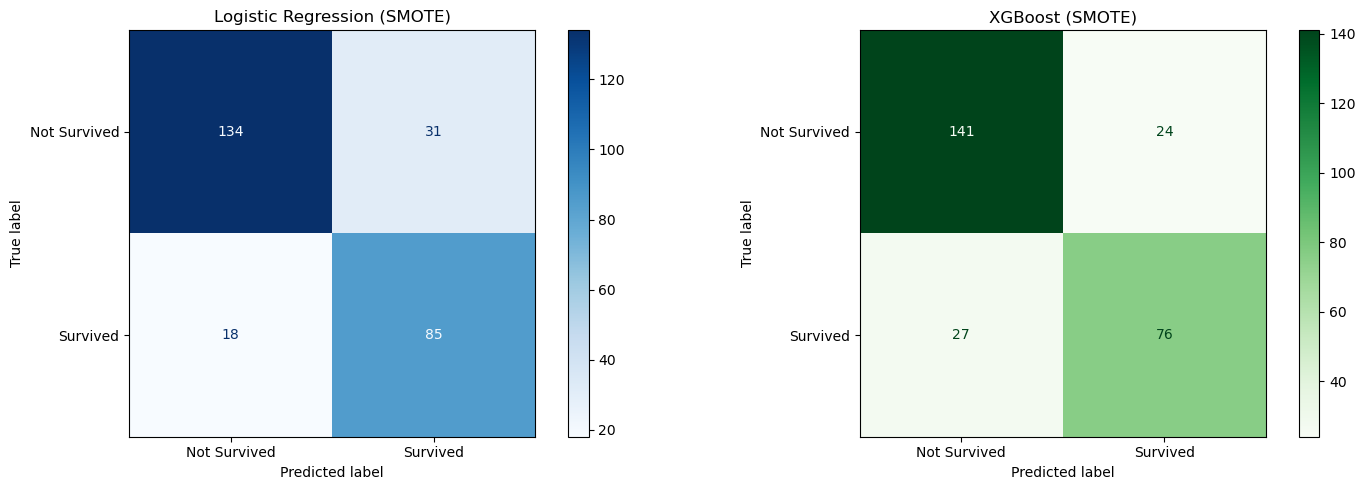

In [122]:
# Compare Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(best_logreg, X_test, y_test, ax=ax[0], 
                                      cmap='Blues', display_labels=['Not Survived', 'Survived'])
ax[0].set_title("Logistic Regression (SMOTE)")

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, ax=ax[1], 
                                      cmap='Greens', display_labels=['Not Survived', 'Survived'])
ax[1].set_title("XGBoost (SMOTE)")
plt.tight_layout()
plt.savefig('Titan_image/Logistic Regression (SMOTE).png', dpi=300, bbox_inches='tight')
plt.show()


# Model Evaluation

In [123]:
#  Final Model Evaluation and Comparison
print("FINAL MODEL EVALUATION ON TEST SET")


best_models = {
    "Logistic Regression": logReg_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

# Detailed evaluation
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': roc_auc,
        'Avg Precision': avg_precision
    })
    
    print(f"\n{name}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Average Precision: {avg_precision:.4f}")
    print("\n  Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

FINAL MODEL EVALUATION ON TEST SET

Logistic Regression
  Accuracy: 0.8172
  ROC-AUC: 0.8702
  Average Precision: 0.8317

  Confusion Matrix:
[[134  31]
 [ 18  85]]

XGBoost
  Accuracy: 0.8097
  ROC-AUC: 0.8747
  Average Precision: 0.8251

  Confusion Matrix:
[[141  24]
 [ 27  76]]


SUMMARY OF ALL MODELS
              Model  Accuracy  ROC-AUC  Avg Precision
Logistic Regression  0.817164 0.870168       0.831732
            XGBoost  0.809701 0.874669       0.825119


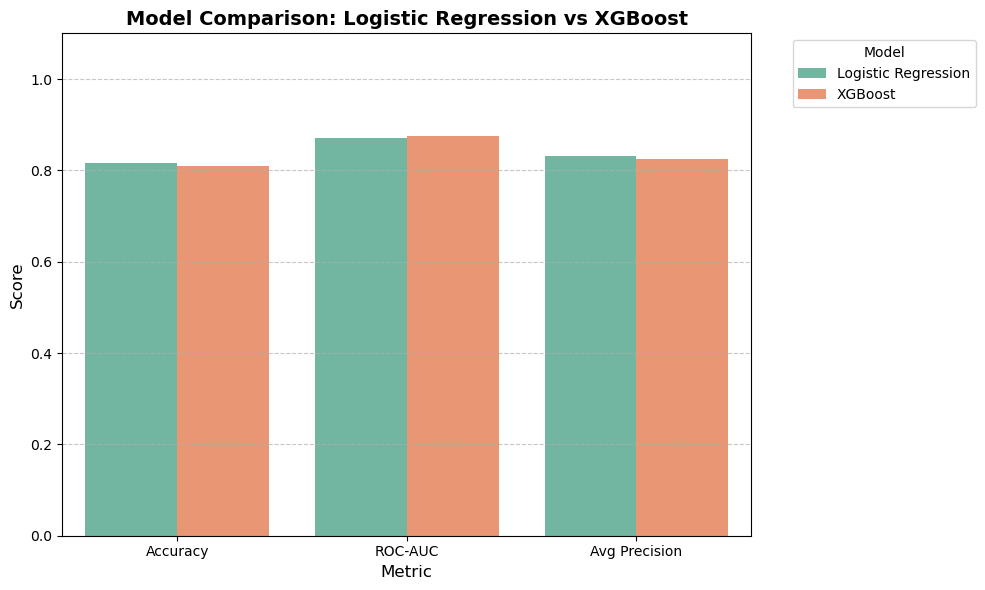

In [128]:
# Results Summary
results_df = pd.DataFrame(results)
print("SUMMARY OF ALL MODELS")
print(results_df.to_string(index=False))

# Visualize Model Comparison
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Model Comparison: Logistic Regression vs XGBoost', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Titan_image/Model.png', dpi=300, bbox_inches='tight')
plt.show()

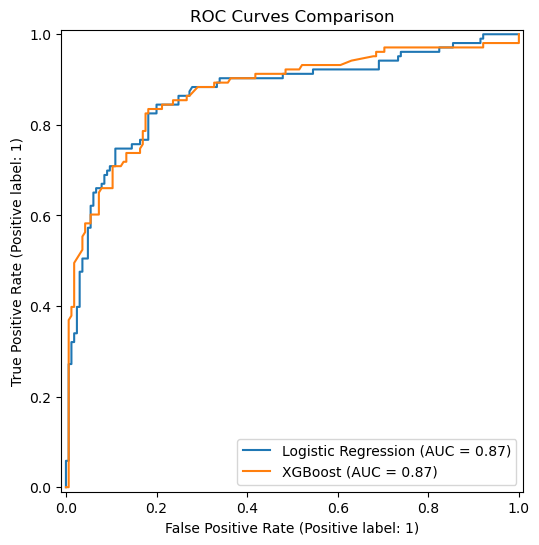

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))
for name, model in best_models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, 
                                    ax=ax, name=name)
plt.title('ROC Curves Comparison')
plt.savefig('Titan_image/ROC Curves Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [131]:
# predictions generated from test data
X_predictions = test_data.drop(columns=['PassengerId', 'Name', 'Ticket'], 
                              errors='ignore')
predictions = best_xgb.predict(X_predictions)

predictions = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})
predictions.to_csv('predictions.csv', index=False)